# 1. Import the required libraries

In [2]:
# Standard code libraries
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Custom code libraries from ReSurfEMG
from resurfemg.data_connector.config import Config
from resurfemg.pipelines import ipy_widgets
from resurfemg.data_connector import file_discovery
from resurfemg.data_connector.converter_functions import load_file
from resurfemg.postprocessing import features as feat
from resurfemg.postprocessing import quality_assessment as qa

from resurfemg.data_connector.data_classes import (
    VentilatorDataGroup, EmgDataGroup)

%matplotlib widget

## 2. Load the ventilator and sEMG data

### 2a With test data

In [3]:
# Identify all recordings available for the selected patient/measurement_date

# First find the patients
config = Config()

# Then find the files for the selected patients:
base_path = config.get_directory('test_data')
folder_levels = None

emg_files = file_discovery.find_files(
    base_path=base_path,
    file_name_regex='emg_data_synth_*',
    extension_regex='*',
    folder_levels=folder_levels)

vent_files = file_discovery.find_files(
    base_path=base_path,
    file_name_regex='vent_data_synth_*',
    extension_regex='*',
    folder_levels=folder_levels)
folder_levels = ['files']

### 2b II - With structured patient data (faster for many datasets)

In [4]:
# # First find the patients
# config = Config()
# base_path = config.get_directory('patient_data')
# patients = file_discovery.find_folders(base_path)

# # Select the patient
# # Create a dropdown widget for patient selection
# patient_dropdown = widgets.Dropdown(
#     options=patients['destination'].tolist(),
#     description='Patient:',
#     disabled=False,
# )

# # Display the dropdown widget
# display(patient_dropdown)

In [5]:
# # Then find the files for the selected patients:
# folder_levels = ['days', 'measurement']

# emg_files = file_discovery.find_files(
#     base_path=os.path.join(base_path, patient_dropdown.value),
#     file_name_regex='EMG*',
#     extension_regex='poly5',
#     folder_levels=folder_levels)
# folder_levels = ['days', 'measurement']
# vent_files = file_discovery.find_files(
#     base_path=os.path.join(base_path, patient_dropdown.value),
#     file_name_regex='Draeger*',
#     extension_regex='poly5',
#     folder_levels=folder_levels)

# emg_files['patient'] = patient_dropdown.value
# vent_files['patient'] = patient_dropdown.value
# folder_levels.insert(0, 'patient')


### 2b II - With structured patient data

In [6]:
# # Find the files for all files that meet the ./patient/day/measurement
# # structure
# config = Config()

# base_path = config.get_directory('patient_data')
# folder_levels = ['patient','days', 'measurement']

# emg_files = file_discovery.find_files(
#     base_path=base_path,
#     file_name_regex='EMG*',
#     extension_regex='poly5',
#     folder_levels=folder_levels)
# folder_levels = ['patient','days', 'measurement']
# vent_files = file_discovery.find_files(
#     base_path=base_path,
#     file_name_regex='Draeger*',
#     extension_regex='poly5',
#     folder_levels=folder_levels)


In [7]:
# If you want to select another file:
btn_list_emg = ipy_widgets.file_select(
    emg_files,
    folder_levels=folder_levels,
    default_value_select=None,
    default_idx_select=[1])
btn_list_vent = ipy_widgets.file_select(
    vent_files,
    folder_levels=folder_levels,
    default_value_select=None,
    default_idx_select=[1])

interactive(children=(Dropdown(description='files:', index=1, options=('emg_data_synth_pocc.Poly5', 'emg_data_…

interactive(children=(Dropdown(description='files:', index=1, options=('vent_data_synth_pocc.Poly5', 'vent_dat…

In [8]:
# Load the EMG and ventilator data recordings from the selected folders.
emg_file_chosen = os.path.join(base_path, *[btn.value for btn in btn_list_emg])
vent_file_chosen = os.path.join(base_path, *[btn.value for btn in btn_list_vent])

# Store the EMG data in a group of TimeSeries objects
print('--- Loading EMG data ---')
y_emg, _, metadata_emg = load_file(emg_file_chosen, verbose=True)
emg_timeseries = EmgDataGroup(
    y_emg,
    fs=metadata_emg['fs'],
    labels=metadata_emg['labels'],
    units=metadata_emg['units'] )

# Store the ventilator data in a group of TimeSeries objects
print('\n--- Loading ventilator data ---')
y_vent, _, metadata_vent = load_file(vent_file_chosen, verbose=True)
vent_timeseries = VentilatorDataGroup(
    y_vent,
    fs=metadata_vent['fs'],
    labels=metadata_vent['labels'],
    units=metadata_vent['units'])

--- Loading EMG data ---
Detected .poly5
Loading .Poly5 ...
Reading file  C:\Users\WarnaarRSP\Repos\ReSurfEMG\ReSurfEMG\test_data\emg_data_synth_quiet_breathing.Poly5
	 Number of samples:  860160 
	 Number of channels:  2 
	 Sample rate: 2048 Hz
Done reading data.
Loaded .Poly5, extracting data ...
Loading data completed
Selected channels: [0, 1]
Auto-detected ECG channel from labels.

--- Loading ventilator data ---
Detected .poly5
Loading .Poly5 ...
Reading file  C:\Users\WarnaarRSP\Repos\ReSurfEMG\ReSurfEMG\test_data\vent_data_synth_quiet_breathing.Poly5
	 Number of samples:  42000 
	 Number of channels:  3 
	 Sample rate: 100 Hz
Done reading data.
Loaded .Poly5, extracting data ...
Loading data completed
Selected channels: [0, 1, 2]
Auto-detected Flow channel from labels.


# 3. Pre-process the data

In [9]:
# Filter
emg_timeseries.run('filter_emg')

In [11]:
ts = emg_timeseries[0]
help(ts.set_peaks)

Help on method set_peaks in module resurfemg.data_connector.data_classes:

set_peaks(peak_idxs, signal, peak_set_name, overwrite=False) method of resurfemg.data_connector.data_classes.TimeSeries instance
    Store a new PeaksSet object in the self.peaks dict under the key
    peak_set_name.
    -----------------------------------------------------------------------
    :returns: None
    :rtype: None



In [ ]:
# ECG removal
# ECG peak detection:
emg_timeseries.run('get_ecg_peaks', overwrite=True)
# OR Set the peaks manually:
# emg_timeseries.run('set_peaks', ecg_peak_idxs, y_ecg, 'ecg', overwrite=True)


# Through gating
emg_timeseries.run('gating')

# # Through wavelet denoising
# emg_timeseries.run('wavelet_denoising')
# # emg_timeseries.run('wavelet_denoising', n=8, fixed_threshold=8.0)

Set ECG channel used for ECG peak detection.


In [11]:
# Calculate the envelope of the signal
emg_timeseries.run('envelope')
# emg_timeseries.run('envelope', ci_alpha=0.05)
# emg_timeseries.run('envelope', env_type='arv')
# emg_timeseries.run('envelope', env_type='arv', ci_alpha=0.05)

In [12]:
# Calculate the baseline for the EMG envelopes and p_vent
emg_timeseries.run('baseline')
vent_timeseries.run(
    'baseline',
    channel_idxs=[0],
    signal_type='raw')

(0.0, 10.0)

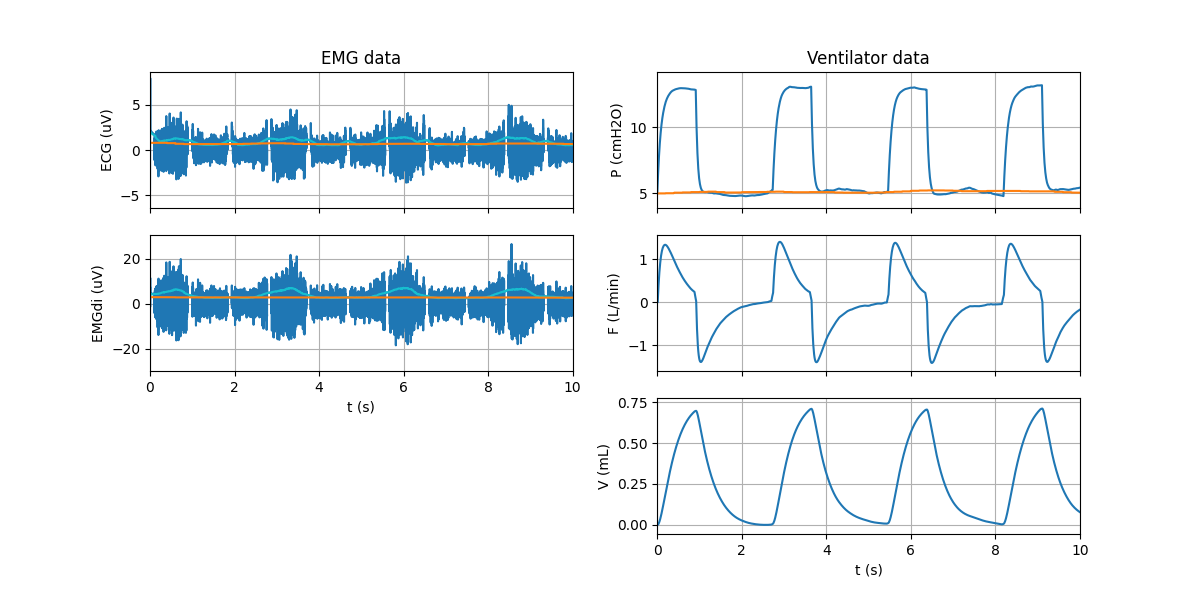

In [13]:
# Plot the raw data with the envelope
# EMG data
n_rows = max([len(emg_timeseries.channels), len(vent_timeseries.channels)])
fig, axis = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, n_rows*2), sharex=True)
axes_emg = axis[:len(emg_timeseries.channels), 0]
colors = ['tab:cyan', 'tab:orange']
emg_timeseries.run(
    'plot_full', axes=axes_emg, signal_type='clean', baseline_bool=False)
emg_timeseries.run(
    'plot_full', axes=axes_emg, signal_type='env', colors=colors)

axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

# Ventilator data data
axes_vent = axis[:, 1]
vent_timeseries.run('plot_full', axes=axes_vent)
axes_vent[0].set_title('Ventilator data')
axes_vent[-1].set_xlabel('t (s)')

if n_rows > len(emg_timeseries.channels):
    for ax_idx in range(len(emg_timeseries.channels), n_rows):
        axis[ax_idx, 0].axis('off')
    axis[len(emg_timeseries.channels)-1, 0].tick_params(
        axis='x', which='both', labelbottom=True)

axes_emg[-1].set_xlim([0, 10])

# 3. Identify supported breaths in p_vent

In [14]:
# Set p_vent_idx if it is not already set
if vent_timeseries.p_vent_idx is None:
    vent_timeseries.p_vent_idx = 0

# Set v_vent_idx if it is not already set
if vent_timeseries.v_vent_idx is None:
    vent_timeseries.v_vent_idx = 2

In [ ]:
# Find supported breath pressures
p_vent = vent_timeseries[vent_timeseries.p_vent_idx]
v_vent = vent_timeseries[vent_timeseries.v_vent_idx]
vent_timeseries.find_tidal_volume_peaks()
p_vent.peaks['ventilator_breaths'].detect_on_offset(
    baseline=p_vent.y_baseline
)


# 4. Identify all sEMG breaths

Two strategies can be employed: 
- a. detect any EMG peak that can possibly a breath and eliminate implausible breaths based on the quality criteria;
- b. detect only higher EMG peaks by using a higher threshold for detection.

The former is used below. The latter can be implemented by setting additional parameters for the detect_emg_breaths method.

In [ ]:
# Find sEAdi peaks in one channel (sEAdi)
emg_di = emg_timeseries['EMGdi']
emg_di.detect_emg_breaths(peak_set_name='breaths')
# emg_di.detect_emg_breaths(peak_set_name='breaths', prominence_factor=1.5)

# Similar to above for Pocc and ventilator breaths:
emg_di.peaks['breaths'].detect_on_offset(
    baseline=emg_di.y_baseline
)

# 5. Calculate features

In [ ]:
# Respiratory rates based on ventilator data
tv_idxs = v_vent.peaks['ventilator_breaths']['peak_idx']
rr_vent, _ = feat.respiratory_rate(
    tv_idxs, metadata_vent['fs'])

rr_vent, _ = feat.respiratory_rate(
    v_vent.peaks['ventilator_breaths']['peak_idx'],
    v_vent.param['fs'])
v_vent.param['rr'] = rr_vent
p_vent.param['rr'] = rr_vent
print('The detected respiratory rate in the ventilator data is: '
      + f'{round(rr_vent, 1)} /min')

# Respiratory rates based on EMG data
emg_di_idxs = emg_di.peaks['breaths']['peak_idx']
rr_emg, _ = feat.respiratory_rate(
    emg_di_idxs, metadata_emg['fs']
)
emg_di.param['rr'] = rr_emg
print('The detected respiratory rate in the sEAdi data is: '
      + f'{round(rr_emg, 1)} /min')

In [ ]:
# EMG amplitudes
emg_di_pocc_idxs = emg_di.peaks['breaths']['peak_idx']
sEAdi_amplitudes = feat.amplitude(
    signal=emg_di.y_env,
    peak_idxs=emg_di_pocc_idxs,
    baseline=emg_di.y_baseline,
)
emg_di.peaks['breaths'].peak_df['amplitude'] = sEAdi_amplitudes

In [ ]:
# Calculate ETPdi
emg_di.calculate_time_products(
    peak_set_name='breaths', parameter_name='ETPdi')

# 6. Test sEMG quality

In [ ]:
# Test EMG quality on an individual peak basis. This includes the following
# tests:
# - interpeak_distance: EMG interpeak time as compared to ECG interbeat time
# - snr: pseudo signal-to-noise ratio
# - aub: area under the baseline relative to total ETP
# - curve_fit: deviation of the bell curve fit relative to total ETP
#
# Relative ETP and AUB tested during a second stage, including only peaks that
# passed the first stage.

parameter_names = {
    'time_product': 'ETPdi'
}
emg_di.test_emg_quality(
    skip_tests=['relative_etp', 'relative_aub'],
    peak_set_name='breaths',
    parameter_names=parameter_names,
    verbose=False)

In [ ]:
# Remove peaks that did not pass the quality tests
emg_di.peaks['breaths'].sanitize()

In [ ]:
# Test EMG quality for relative_etp and relative_aub
parameter_names = {
    'time_product': 'ETPdi'
}
emg_di.test_emg_quality(
    skip_tests=[],
    peak_set_name='breaths',
    parameter_names=parameter_names,
    verbose=False)

In [ ]:
# Plot identified peaks
fig, axis = plt.subplots(nrows=n_rows, ncols=2, figsize=(n_rows*3, 6), sharex=True)
axes_emg = axis[:len(emg_timeseries.channels), 0]

colors = ['tab:cyan', 'tab:orange']
# emg_timeseries.run(
#     'plot_full', axes=axes_emg, signal_type='clean', baseline_bool=False)
emg_timeseries.run(
    'plot_full', axes=axes_emg, signal_type='env')
emg_timeseries[1].plot_markers(
    peak_set_name='breaths', axes=axes_emg[1], valid_only=True)

axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

# Ventilator data data
axes_vent = axis[:, 1]
vent_timeseries.run('plot_full', axes=axes_vent)
axes_vent[0].set_title('Ventilator data')
axes_vent[-1].set_xlabel('t (s)')


if n_rows > len(emg_timeseries.channels):
    for ax_idx in range(len(emg_timeseries.channels), n_rows):
        axis[ax_idx, 0].axis('off')
    axis[len(emg_timeseries.channels)-1, 0].tick_params(
        axis='x', which='both', labelbottom=True)

axes_vent[-1].set_xlim([0 , 10])

# 5. Link EMG breaths to closest Ventilator breaths

In [ ]:
# Find the EMG peaks with the peak timing closest to the Pocc timings, and
# link ventilator Pocc peaks to EMG breaths
t_peaks_vent = p_vent.peaks['ventilator_breaths']['peak_idx'] / p_vent.param['fs']

emg_di.link_peak_set(
    peak_set_name='breaths',
    t_reference_peaks=t_peaks_vent,
    linked_peak_set_name='linked_breaths',
)

In [ ]:
# Eliminate linked peaks that do not fall within the set window around the
# tidal volume peak
cutoff = {}
cutoff['fraction_emg_breaths'] = 0.1
cutoff['delta_min'] = -0.5
cutoff['delta_max'] = 30 / v_vent.param['rr']
emg_di.test_linked_peak_sets(
    'linked_breaths', v_vent, 'ventilator_breaths', cutoff=cutoff, verbose=False)

In [ ]:
emg_di.peaks['linked_breaths'].sanitize()

In [ ]:
# Create a new peak set for the linked peaks in the ventilator timeseries
t_emg_breaths = emg_di.peaks['linked_breaths']['peak_idx'] / emg_di.param['fs']

v_vent.link_peak_set(
    peak_set_name='ventilator_breaths',
    t_reference_peaks=t_emg_breaths,
    linked_peak_set_name='linked_breaths',
)


In [ ]:
# Test general signal characteristics
emg_di_idxs = emg_di.peaks['linked_breaths']['peak_idx']

fraction_emg_breaths, _ = qa.evaluate_respiratory_rates(
    emg_breath_idxs=emg_di_idxs,
    t_emg=max(emg_di.t_data),
    rr_vent=rr_vent
)
print('The fraction detected EMG breaths is: {:0.2f} %'.format(
    100*fraction_emg_breaths))

## 6 Plot a subset of identified ventilator and sEMG peaks

In [ ]:
# Create new peak sets with the first 4 breaths
t_first_emg_peaks = (
    emg_di.peaks['linked_breaths'].peak_df.loc[:3, 'peak_idx'].to_numpy()
    / metadata_emg['fs'])
emg_di.link_peak_set(
    peak_set_name='linked_breaths',
    t_reference_peaks=t_first_emg_peaks,
    linked_peak_set_name='first_breaths',
)

p_vent.link_peak_set(
    peak_set_name='ventilator_breaths',
    t_reference_peaks=t_first_emg_peaks,
    linked_peak_set_name='first_breaths',
)
v_vent.link_peak_set(
    peak_set_name='ventilator_breaths',
    t_reference_peaks=t_first_emg_peaks,
    linked_peak_set_name='first_breaths',
)


In [ ]:
# Plot the identified Pocc peaks in p_vent and sEAdi
fig, axis = plt.subplots(nrows=n_rows, ncols=2, figsize=(n_rows*3, 6), sharex=True)
axes_emg = axis[:len(emg_timeseries.channels), 0]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_timeseries.run('plot_full', axes=axes_emg, signal_type='env')
emg_di.plot_markers(peak_set_name='first_breaths', axes=axes_emg[1])


axes_emg[1].set_ylabel('sEAdi (uV)')
axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

axes_vent = axis[:, 1]
vent_timeseries.run('plot_full', axes=axes_vent)
p_vent.plot_markers(peak_set_name='first_breaths', axes=axes_vent[0])
v_vent.plot_markers(peak_set_name='first_breaths', axes=axes_vent[2])

axes_vent[0].set_title('Ventilator data')
axes_vent[-1].set_xlabel('t (s)')

if n_rows > len(emg_timeseries.channels):
    for ax_idx in range(len(emg_timeseries.channels), n_rows):
        axis[ax_idx, 0].axis('off')
    axis[len(emg_timeseries.channels)-1, 0].tick_params(
        axis='x', which='both', labelbottom=True)


# Let's zoom in on the subset of peaks:
axes_vent[-1].set_xlim([0, 10])

In [ ]:
# Plot the individual peaks bell-fit

n_peaks = len(emg_di.peaks['first_breaths'].peak_df['start_idx'])
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(10, 6), sharey='row')

axes_emg = axis[0, :]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di.plot_peaks(axes=axes_emg, peak_set_name='first_breaths')
emg_di.plot_markers(axes=axes_emg, peak_set_name='first_breaths')
emg_di.plot_curve_fits(axes=axes_emg, peak_set_name='first_breaths')
axes_emg[0].set_ylabel('sEAdi (uV)')

axes_vent = axis[1, :]
p_vent.plot_peaks(axes=axes_vent, peak_set_name='first_breaths')
p_vent.plot_markers(axes=axes_vent, peak_set_name='first_breaths')

for axis in axes_vent:
    axis.set_xlabel('t (s)')

In [ ]:
# Plot the individual peaks area under the baseline
n_peaks = len(emg_di.peaks['first_breaths']['start_idx'])
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(10, 6), sharey='row')

axes_emg = axis[0, :]
emg_di.plot_aub(axes=axes_emg, signal_type='env', peak_set_name='first_breaths')
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di.plot_peaks(axes=axes_emg, peak_set_name='first_breaths')
emg_di.plot_markers(axes=axes_emg, peak_set_name='first_breaths')
axes_emg[0].set_ylabel('sEAdi (uV)')

axes_vent = axis[1, :]
p_vent.plot_peaks(axes=axes_vent, peak_set_name='first_breaths')
p_vent.plot_markers(axes=axes_vent, peak_set_name='first_breaths')

for axis in axes_vent:
    axis.set_xlabel('t (s)')